In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder

import cv2
from sklearn.metrics import classification_report
from torchvision.models import mobilenet_v2

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision


In [2]:
data_dir = "../input/flowers/flowers/"  # Change this to the path of the dataset on your system
classes = os.listdir(data_dir)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")


Number of classes: 16
Classes: ['astilbe', 'daffodil', 'black_eyed_susan', 'bellflower', 'common_daisy', 'coreopsis', 'dandelion', 'water_lily', 'carnation', 'calendula', 'california_poppy', 'sunflower', 'tulip', 'rose', 'magnolia', 'iris']


In [3]:
data_dir = "../input/flowers/flowers/"
class_names = os.listdir(data_dir)
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# analyzing the dataset, determining the no. of classes, dimesnions and files/class.
rows = []
file_count = 0
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_files = len(os.listdir(class_dir))
    total_width = 0
    total_height = 0
    
    for img_name in os.listdir(class_dir):
        try:
          img_path = os.path.join(class_dir, img_name)
          img = cv2.imread(img_path)
          height, width, channels = img.shape
          total_width += width
          total_height += height
          file_count += 1
        except Exception as e:
          print(img_path)
          print(str(e))
    avg_width = total_width // num_files
    avg_height = total_height // num_files
    rows.append({"Class": class_name, "NumFiles": num_files, "AvgWidth": avg_width, "AvgHeight": avg_height})

df = pd.DataFrame(rows)
print(df)
print("Total files: ",file_count)

               Class  NumFiles  AvgWidth  AvgHeight
0            astilbe       737       256        256
1           daffodil       970       256        256
2   black_eyed_susan      1000       256        256
3         bellflower       873       256        256
4       common_daisy       980       256        256
5          coreopsis      1047       256        256
6          dandelion      1052       256        256
7         water_lily       982       781        586
8          carnation       923       256        256
9          calendula       978       256        256
10  california_poppy      1022       256        256
11         sunflower      1027       256        256
12             tulip      1048       256        256
13              rose       999       256        256
14          magnolia      1048       256        256
15              iris      1054       256        256
Total files:  15740


In [6]:
# Hyperparameters
num_epochs = 25
batch_size = 128
learning_rate = 0.0001

In [7]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize(224),             
        transforms.CenterCrop(224),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [8]:
dataset = ImageFolder(root='../input/flowers/flowers', transform=train_transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# creating dataloaders with batch size of 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [9]:
model = models.mobilenet_v2(pretrained=True)


# Replace the last layer of the fully connected part of the network
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)


# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
from tqdm import tqdm

train_losses = []
metrics =[]
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 7

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}')):
        # Move data to device
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(scores.data, 1)
        total += targets.size(0)
        correct += (predictions == targets).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):

            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

            _, predictions = torch.max(scores.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        metrics.append([epoch+1,train_loss,val_loss,train_accuracy,val_accuracy])


        if val_loss < best_val_loss:
            print("Saving model checkpoint...")
            best_val_loss = val_loss
            checkpoint = {'epoch': epoch+1,
                          'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                          'train_loss': train_loss,
                          'val_loss': val_loss}
            torch.save(checkpoint, 'mobilenetv2TL.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
            print(f"Validation loss did not improve. Patience left: {patience - patience_counter}")
            if patience_counter >= patience:
                print("Stopping training due to early stopping...")
                break

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'mobilenetv2TL.pt')

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Accuracy: {val_accuracy:.2f}%, ',f'Val loss: {val_loss:.4f}, ')


Validation Epoch 1/25: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Saving model checkpoint...
Epoch 1/25, Train Loss: 0.8825, Train Accuracy: 78.80%, Val Accuracy: 90.91%,  Val loss: 0.3151, 


Validation Epoch 2/25: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Saving model checkpoint...
Epoch 2/25, Train Loss: 0.2378, Train Accuracy: 93.48%, Val Accuracy: 93.58%,  Val loss: 0.2219, 


Validation Epoch 3/25: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Saving model checkpoint...
Epoch 3/25, Train Loss: 0.1446, Train Accuracy: 95.95%, Val Accuracy: 94.28%,  Val loss: 0.1839, 


Validation Epoch 4/25: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Saving model checkpoint...
Epoch 4/25, Train Loss: 0.0976, Train Accuracy: 97.39%, Val Accuracy: 94.85%,  Val loss: 0.1746, 


Validation Epoch 5/25: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Saving model checkpoint...
Epoch 5/25, Train Loss: 0.0742, Train Accuracy: 97.84%, Val Accuracy: 94.54%,  Val loss: 0.1687, 


Validation Epoch 6/25: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Saving model checkpoint...
Epoch 6/25, Train Loss: 0.0513, Train Accuracy: 98.73%, Val Accuracy: 95.68%,  Val loss: 0.1397, 


Validation Epoch 7/25: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]


Validation loss did not improve. Patience left: 6
Epoch 7/25, Train Loss: 0.0405, Train Accuracy: 98.87%, Val Accuracy: 94.85%,  Val loss: 0.1536, 


Validation Epoch 8/25: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Validation loss did not improve. Patience left: 5
Epoch 8/25, Train Loss: 0.0275, Train Accuracy: 99.33%, Val Accuracy: 95.04%,  Val loss: 0.1700, 


Validation Epoch 9/25: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Validation loss did not improve. Patience left: 4
Epoch 9/25, Train Loss: 0.0227, Train Accuracy: 99.54%, Val Accuracy: 95.43%,  Val loss: 0.1682, 


Validation Epoch 10/25: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


Validation loss did not improve. Patience left: 3
Epoch 10/25, Train Loss: 0.0356, Train Accuracy: 99.08%, Val Accuracy: 95.24%,  Val loss: 0.1526, 


Validation Epoch 11/25: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Validation loss did not improve. Patience left: 2
Epoch 11/25, Train Loss: 0.0415, Train Accuracy: 98.90%, Val Accuracy: 95.11%,  Val loss: 0.1526, 


Validation Epoch 12/25: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Validation loss did not improve. Patience left: 1
Epoch 12/25, Train Loss: 0.0302, Train Accuracy: 99.10%, Val Accuracy: 95.87%,  Val loss: 0.1420, 


Validation Epoch 13/25: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]

Validation loss did not improve. Patience left: 0
Stopping training due to early stopping...


In [11]:

correct = 0
total = 0
with torch.no_grad():
        for data, targets in tqdm(test_loader, desc=f'Test Epoch {epoch+1}/{num_epochs}'):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)

            _, predictions = torch.max(scores.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

        test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Epoch 13/25: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]

Test Accuracy: 95.43%


In [12]:
train_losses

[0.8824781787463989,
 0.23781512617722325,
 0.1446096652198112,
 0.09760545326889246,
 0.07420716605994893,
 0.05126604634797436,
 0.040516441056354977,
 0.027501890676674145,
 0.02265352688879631,
 0.035567739518123795,
 0.041519378654487515,
 0.030172273738780755,
 0.01354267153803302]

In [13]:
val_losses

[0.315077373614678,
 0.22185869744190803,
 0.18386239959643438,
 0.1745771341598951,
 0.16867880752453437,
 0.13965836396584144,
 0.15356500332172102,
 0.17001525140725648,
 0.16817363236959165,
 0.15255283908202097,
 0.15259585472253653,
 0.14197345794393465,
 0.14934157207608223]

In [14]:
val_accuracies

[90.9148665819568,
 93.58322744599747,
 94.28208386277001,
 94.85387547649302,
 94.53621346886912,
 95.67979669631512,
 94.85387547649302,
 95.04447268106735,
 95.42566709021601,
 95.23506988564168,
 95.10800508259213,
 95.87039390088945,
 95.61626429479034]

In [15]:
train_accuracies

[78.79833000544564,
 93.48339081502995,
 95.9520784171356,
 97.38609548012343,
 97.83989834815756,
 98.72935196950445,
 98.86549282991469,
 99.32837175530949,
 99.5371210746052,
 99.08331820657106,
 98.90179705935742,
 99.10147032129242,
 99.65510982029406]

Test set evaluation: 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


AUC: 0.08


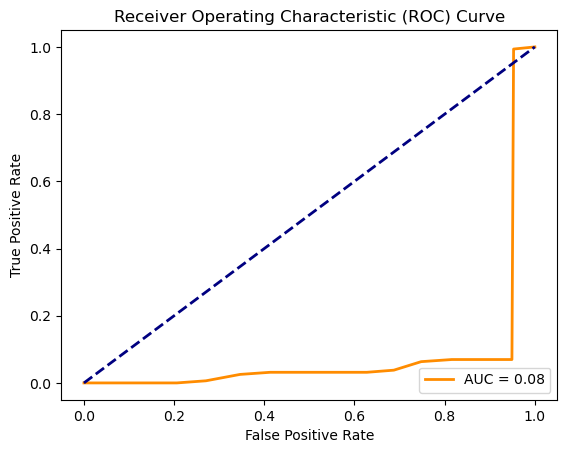

[[136   2   0   0   0   3   2   0   0   0   0   5   0   0   0   1]
 [  1 146   0   0   1   4   1   0   0   0   1   3   1   0   0   0]
 [  0   0 191   0   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   2   0 192   2   0   3   8   0   1   0   0   0   3   0   0]
 [  0   1   0   3 195   1   0   1   0   1   0   0   0   0   1   0]
 [  3   0   0   3   0 162   1   0   0   0   0   5   4   0   0   0]
 [  0   1   0   2   1   1 167   0   1   0   0   2   0   0   1   1]
 [  0   0   1   2   2   0   1 212   0   0   0   0   0   2   1   0]
 [  0   1   0   0   0   1   0   0 205   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0 211   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   1   0 200   0   0   0   0   0]
 [  2   2   0   0   1   3   1   0   0   0   0 214   1   0   0   0]
 [  0   0   0   1   0   9   0   0   0   0   0   0 188   0   0   0]
 [  0   0   2   1   1   0   0   0   0   0   0   0   0 202   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0 207 

In [16]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc=f'Test set evaluation'):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)

        probabilities = nn.functional.softmax(scores, dim=1)

        _, predictions = torch.max(probabilities, 1)

        true_labels += targets.tolist()
        predicted_labels += predictions.tolist()

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)


In [17]:
epochslist = []
for i in range(epoch+1):
    epochslist.append(i+1)
epochslist

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

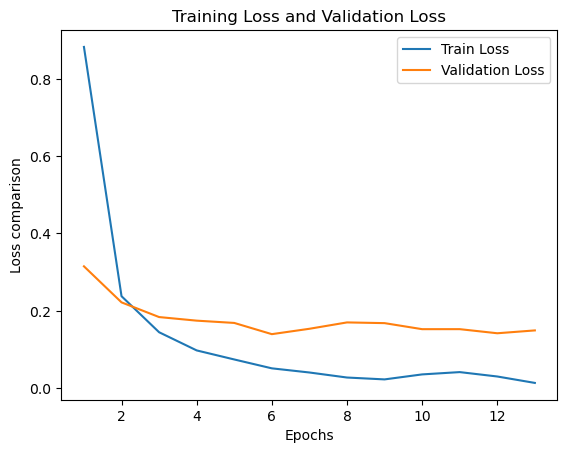

In [18]:
import matplotlib.pyplot as plt

plt.plot(epochslist, train_losses, label='Train Loss')
plt.plot(epochslist, val_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss comparison')

plt.legend()

plt.show()

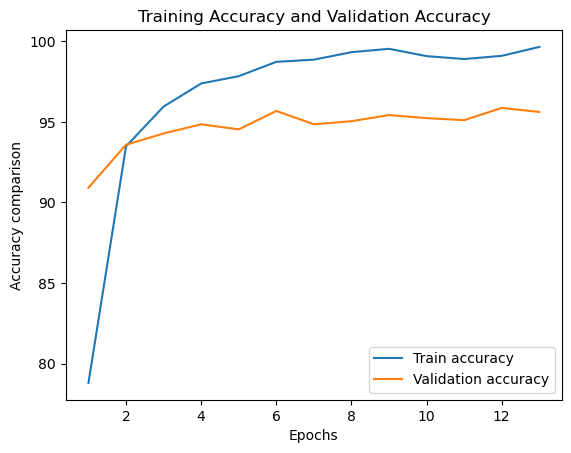

In [19]:
import matplotlib.pyplot as plt

plt.plot(epochslist, train_accuracies, label='Train accuracy')
plt.plot(epochslist, val_accuracies, label='Validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy comparison')

plt.legend()
plt.show()

In [20]:
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[136   2   0   0   0   3   2   0   0   0   0   5   0   0   0   1]
 [  1 146   0   0   1   4   1   0   0   0   1   3   1   0   0   0]
 [  0   0 191   0   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   2   0 192   2   0   3   8   0   1   0   0   0   3   0   0]
 [  0   1   0   3 195   1   0   1   0   1   0   0   0   0   1   0]
 [  3   0   0   3   0 162   1   0   0   0   0   5   4   0   0   0]
 [  0   1   0   2   1   1 167   0   1   0   0   2   0   0   1   1]
 [  0   0   1   2   2   0   1 212   0   0   0   0   0   2   1   0]
 [  0   1   0   0   0   1   0   0 205   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   4   0   0 211   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   1   0 200   0   0   0   0   0]
 [  2   2   0   0   1   3   1   0   0   0   0 214   1   0   0   0]
 [  0   0   0   1   0   9   0   0   0   0   0   0 188   0   0   0]
 [  0   0   2   1   1   0   0   0   0   0   0   0   0 202   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0 207 

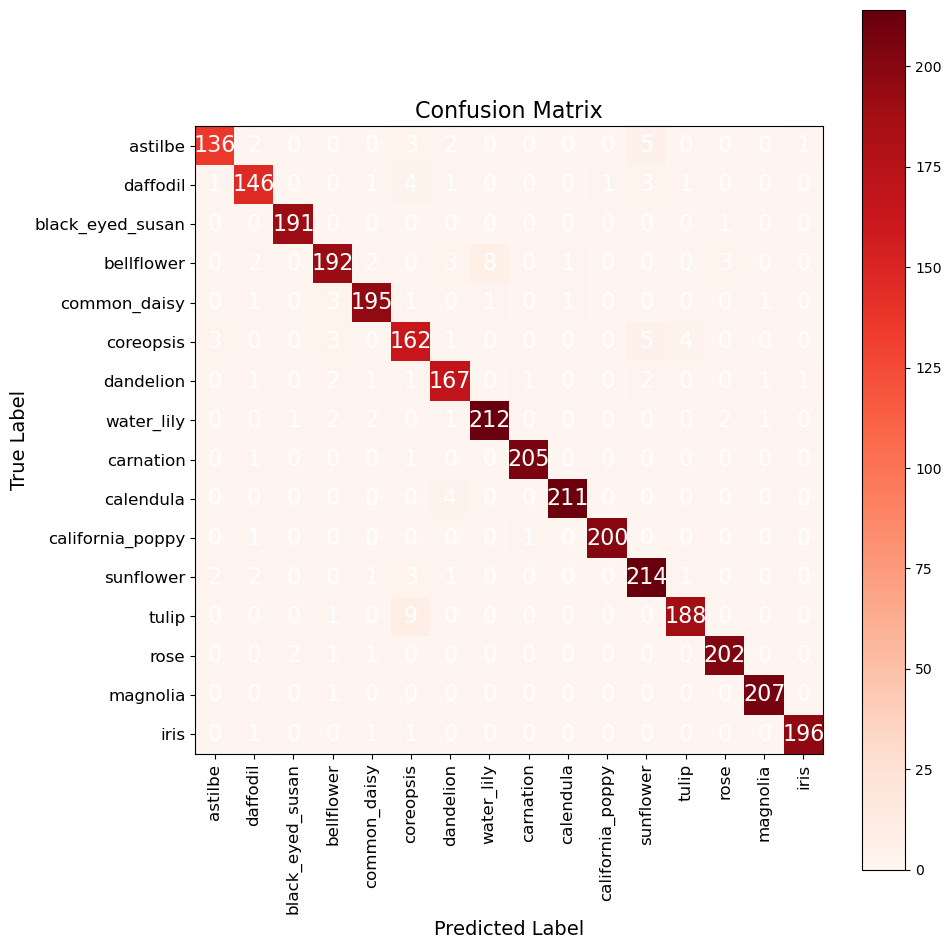

In [21]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Reds)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
plt.show()

In [22]:
precision = sum([cm[i, i] / sum(cm[:, i]) for i in range(len(class_names))]) / len(class_names)
recall = sum([cm[i, i] / sum(cm[i, :]) for i in range(len(class_names))]) / len(class_names)
accuracy = sum([cm[i, i] for i in range(len(class_names))]) / np.sum(cm)
f1_score = 2 * (precision * recall) / (precision + recall)

print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1-score: {:.2f}%'.format(f1_score * 100))

Precision: 95.96%
Recall: 95.89%
Accuracy: 96.06%
F1-score: 95.93%


In [23]:
metrics_as_numpy = np.array(metrics)

np.save('mobilenetv2TL.npy', metrics_as_numpy)
